In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv('Cohort_analysis.csv')
df

,day,customer_id,customer_type,total_sales
0,2018-01-01,65798701081,Returning,30.80
1,2018-01-01,263760969753,First-time,82.80
2,2018-01-01,4507624326,Returning,26.00
3,2018-01-01,5982990732,Returning,128.16
4,2018-01-01,31019499545,Returning,66.00
...,...,...,...,...
90295,2019-12-31,6348897036,Returning,-2.50
90296,2019-12-31,1216271089748,Returning,25.00
90297,2019-12-31,3068475408468,First-time,213.09
90298,2019-12-31,2949441028180,Returning,32.80


In [28]:
#Separate first time customers from returning customers
first_time = df.loc[df['customer_type'] == 'First-time',]
final = df.loc[df['customer_id'].isin(first_time['customer_id'].values)]
final = final.drop(columns = ['customer_type'])
final = final.sort_values(['customer_id','day'])
final.reset_index(inplace = True, drop = True)

It's time to create purchase rate, join date, age by month functions
*purchase_rate: determine whether that is a 2nd, 3rd, 4th purchase of each customer.

*join_date: find the date when the customer joins.

*age_by_month: get the number of months from the current purchase of a customer to the first time purchase.

In [31]:
def purchase_rate(customer_id):
    purchase_rate = [1]
    counter = 1
    for i in range(1,len(customer_id)):
        if customer_id[i] != customer_id[i-1]:
                 purchase_rate.append(1)
                 counter = 1
        else:
                    counter += 1
                    purchase_rate.append(counter)
    return purchase_rate
def join_date(date, purchase_rate):
    join_date = list(range(len(date)))
    for i in range(len(purchase_rate)): 
        if purchase_rate[i] == 1:
            join_date[i] = date[i]
        else:
                 join_date[i] = join_date[i-1]
    return join_date
def age_by_month(purchase_rate, month, year, join_month, join_year):
    age_by_month = list(range(len(year)))
    for i in range(len(purchase_rate)):
        if purchase_rate[i] == 1:
            age_by_month[i] = 0
        else:
                if year[i] == join_year[i]:
                    age_by_month[i] = month[i] - join_month[i]
                else:
                    age_by_month[i] = month[i] - join_month[i] + 12*(year[i]-join_year[i])
    return age_by_month

In [32]:
#Create cohorts

final['month'] =pd.to_datetime(final['day']).dt.month
final['Purchase Rate'] = purchase_rate(final['customer_id'])
final['Join Date'] = join_date(final['day'], final['Purchase Rate'])
final['Join Date'] = pd.to_datetime(final['Join Date'], dayfirst=True)
final['cohort'] = pd.to_datetime(final['Join Date']).dt.strftime('%Y-%m')
final['year'] = pd.to_datetime(final['day']).dt.year
final['Join Date Month'] = pd.to_datetime(final['Join Date']).dt.month
final['Join Date Year'] = pd.to_datetime(final['Join Date']).dt.year
final['Age by month'] = age_by_month(final['Purchase Rate'], final['month'],final['year'],final['Join Date Month'],final['Join Date Year'])
cohorts = final.groupby(['cohort','Age by month']).nunique()
cohorts = cohorts.customer_id.to_frame().reset_index()   # convert series to frame
cohorts = pd.pivot_table(cohorts, values = 'customer_id',index = 'cohort', columns= 'Age by month')
cohorts.replace(np.nan, '',regex=True)

Age by month,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cohort,,,,,,,,,,,,,,,,,,,,,
2018-01,462.0,121,125,113,111,107,101,103,87,86,...,94,88,98,72,87,69,61,77,74,80
2018-02,483.0,134,132,117,113,115,94,106,96,115,...,98,84,81,86,70,74,65,82,83,
2018-03,508.0,143,149,121,123,109,117,114,125,111,...,94,80,87,78,83,72,94,83,,
2018-04,540.0,130,127,133,117,116,113,145,119,124,...,98,108,96,94,95,113,100,,,
2018-05,548.0,152,150,136,123,143,126,114,116,108,...,118,94,91,102,110,113,,,,
2018-06,548.0,149,163,154,115,164,108,112,110,118,...,102,86,81,108,93,,,,,
2018-07,553.0,140,136,138,153,128,128,108,132,114,...,109,103,117,111,,,,,,
2018-08,638.0,165,176,176,161,124,129,151,126,132,...,106,109,124,,,,,,,
2018-09,623.0,139,148,129,126,116,120,101,118,103,...,103,98,,,,,,,,


In [33]:
#Convert into cohort percentage

for i in range(len(cohorts)-1):
    cohorts[i+1] = cohorts[i+1]/cohorts[0]
cohorts[0] = cohorts[0]/cohorts[0]

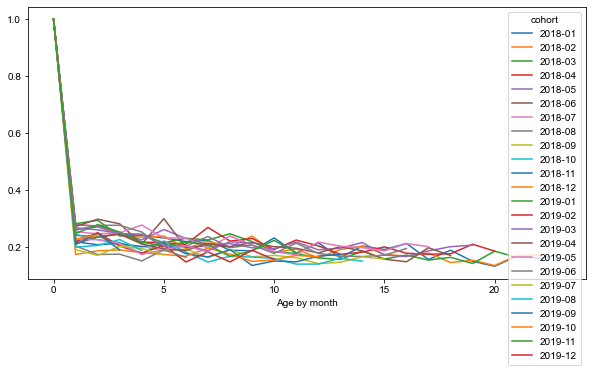

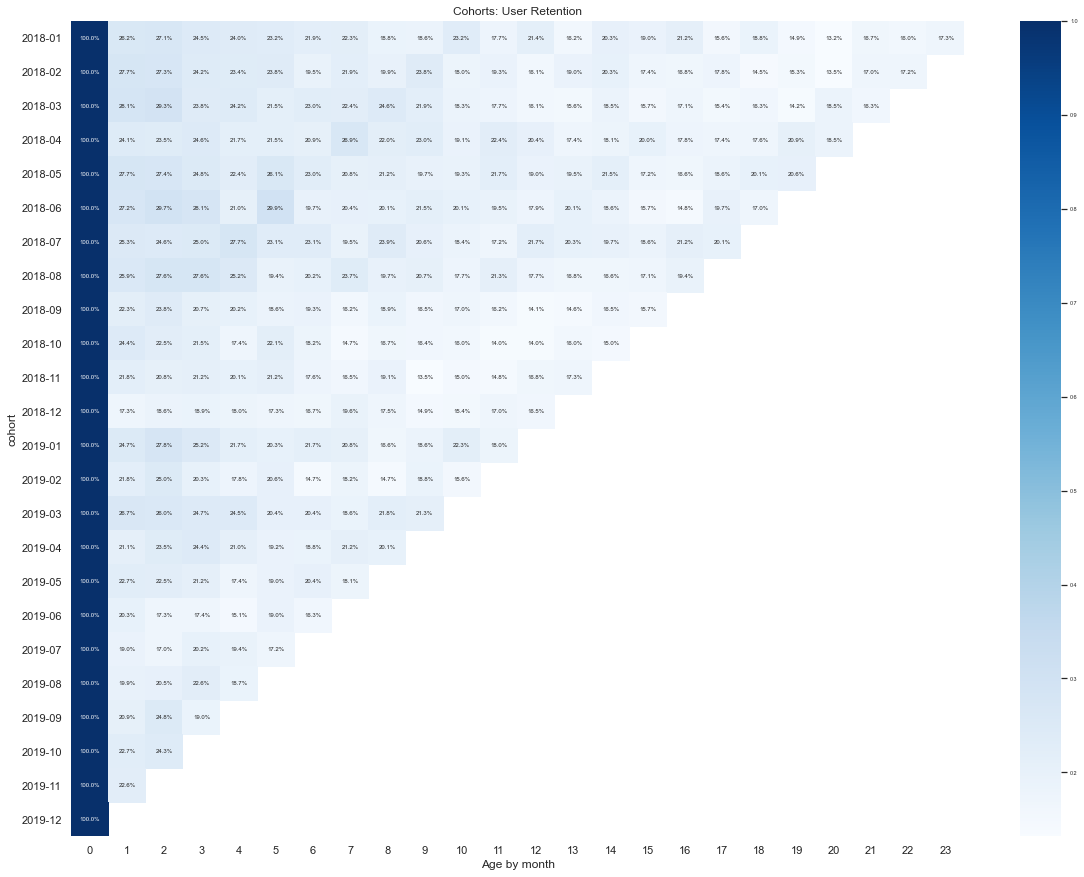

In [34]:
#Visualisation

cohorts_t = cohorts.transpose()
cohorts_t[cohorts_t.columns].plot(figsize=(10,5))
sns.set(style='whitegrid')
plt.figure(figsize=(20, 15))
plt.title('Cohorts: User Retention')
sns.set(font_scale = 0.5)
sns.heatmap(cohorts, mask=cohorts.isnull(),
cmap="Blues",
annot=True, fmt='.01%')
plt.show()